### CIFAR10 Image Classification Project using Convolutional Neural Networks in PyTorch

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Hyper parameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# datasaet has PILImage images of range [0,1]
# We transform them to Tensors of normalized range [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

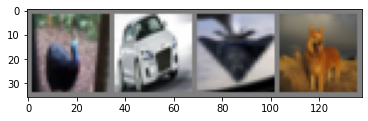

In [16]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

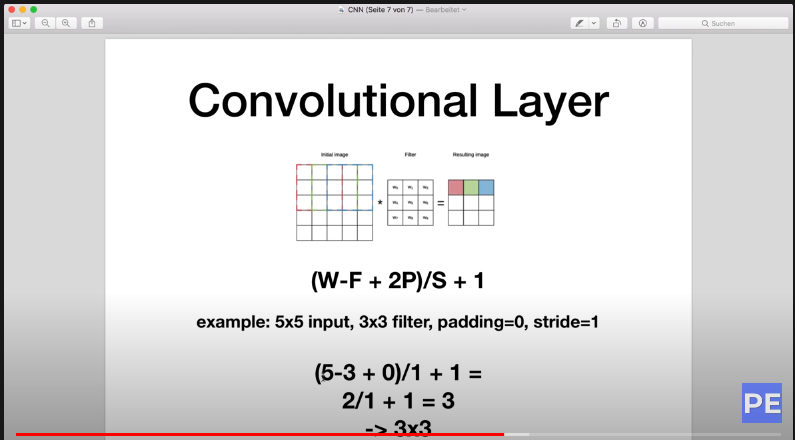



In [17]:
# Demonstration of application of convolutional layers for understanding (see the above image)
conv1 = nn.Conv2d(3,6,5)
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6, 16, 5)
print(images.shape)

torch.Size([4, 3, 32, 32])


In [18]:
x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape) 

torch.Size([4, 6, 28, 28])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 10, 10])
torch.Size([4, 16, 5, 5])


In [20]:
# implementing convolutional neural networks
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120) # fully connected layer 1
        self.fc2 = nn.Linear(120, 84) # fully connected layer 2
        self.fc3 = nn.Linear(84, 10) # fully connected layer 3

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4 , 3, 1024
        # input layer: 3 input channels , 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 ==0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Finished Training')

Epoch [1/4], Step [2000/12500], Loss: 2.2943
Epoch [1/4], Step [4000/12500], Loss: 2.3032
Epoch [1/4], Step [6000/12500], Loss: 2.2880
Epoch [1/4], Step [8000/12500], Loss: 2.3145
Epoch [1/4], Step [10000/12500], Loss: 2.2761
Epoch [1/4], Step [12000/12500], Loss: 2.1296
Epoch [2/4], Step [2000/12500], Loss: 2.4333
Epoch [2/4], Step [4000/12500], Loss: 1.7405
Epoch [2/4], Step [6000/12500], Loss: 1.9977
Epoch [2/4], Step [8000/12500], Loss: 1.5991
Epoch [2/4], Step [10000/12500], Loss: 1.3146
Epoch [2/4], Step [12000/12500], Loss: 1.2987
Epoch [3/4], Step [2000/12500], Loss: 1.4210
Epoch [3/4], Step [4000/12500], Loss: 1.9103
Epoch [3/4], Step [6000/12500], Loss: 1.9616
Epoch [3/4], Step [8000/12500], Loss: 1.6276
Epoch [3/4], Step [10000/12500], Loss: 1.6870
Epoch [3/4], Step [12000/12500], Loss: 1.4708
Epoch [4/4], Step [2000/12500], Loss: 2.0311
Epoch [4/4], Step [4000/12500], Loss: 1.1556
Epoch [4/4], Step [6000/12500], Loss: 1.4896
Epoch [4/4], Step [8000/12500], Loss: 1.8176
Epoc

In [24]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 45.1 %
Accuracy of plane: 48.8 %
Accuracy of car: 49.4 %
Accuracy of bird: 36.8 %
Accuracy of cat: 20.8 %
Accuracy of deer: 18.4 %
Accuracy of dog: 52.0 %
Accuracy of frog: 71.5 %
Accuracy of horse: 46.5 %
Accuracy of ship: 52.4 %
Accuracy of truck: 54.4 %
